In [1]:
import ctypes
import serial
from picosdk.ps3000a import ps3000a as ps
from picosdk.functions import mV2adc, adc2mV, assert_pico_ok
import numpy as np
import matplotlib.pyplot as plt
    
from pwn import *
from tqdm import tqdm
import random
import time

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from Trace_processor_pico3000a import TraceProcessor

The ps3000a.dll dynamic link library (DLL) in the SDK allows you to program any supported oscilloscope using standard C function calls.  

A typical program for capturing data consists of the following steps:  
- Open the scope unit.  
- Set up the input channels with the required voltage ranges and coupling type.  
- Set up triggering.  
- Start capturing data. (See Sampling modes, where programming is discussed in more detail.)  
- Wait until the scope unit is ready.  
- Stop capturing data.  
- Copy data to a buffer.  
- Close the scope unit.  

In [2]:
# Step 1: Open the scope unit
# Create chandle and status ready for use

status = {}
chandle = ctypes.c_int16()

# Opens the device/s
status["openunit"] = ps.ps3000aOpenUnit(ctypes.byref(chandle), None)

try:
    assert_pico_ok(status["openunit"])
except:
    
    print("pico not ok?")
    # powerstate becomes the status number of openunit
    powerstate = status["openunit"]

    # If powerstate is the same as 282 then it will run this if statement
    if powerstate == 282:
        # Changes the power input to "PICO_POWER_SUPPLY_NOT_CONNECTED"
        status["ChangePowerSource"] = ps.ps3000aChangePowerSource(chandle, 282)
        # If the powerstate is the same as 286 then it will run this if statement
    elif powerstate == 286:
        # Changes the power input to "PICO_USB3_0_DEVICE_NON_USB3_0_PORT"
        status["ChangePowerSource"] = ps.ps3000aChangePowerSource(chandle, 286)
    else:
        raise

    assert_pico_ok(status["ChangePowerSource"])


print(status["openunit"])

0


In [3]:
# Step 2.a: Input Channel Parameters

#ps3000a.PS3000A_RANGE = make_enum([
#     "PS3000A_10MV",
#     "PS3000A_20MV",
#     "PS3000A_50MV",
#     "PS3000A_100MV",
#     "PS3000A_200MV",
#     "PS3000A_500MV",
#     "PS3000A_1V",
#     "PS3000A_2V",
#     "PS3000A_5V",
#     "PS3000A_10V",
#     "PS3000A_20V",
#     "PS3000A_50V",
#     "PS3000A_MAX_RANGES",
# ])

## Set up parameters of channel A
channel_A = ps.PS3000A_CHANNEL["PS3000A_CHANNEL_A"]
enabled_A = 1
coupling_type_A = ps.PS3000A_COUPLING["PS3000A_DC"] # DC
chARange = ps.PS3000A_RANGE["PS3000A_50MV"] # amplitude
analogue_offset_A = 0.0

# Set up parameters of channel B 
channel_B = ps.PS3000A_CHANNEL["PS3000A_CHANNEL_B"]
enabled_B = 1
coupling_type_B = ps.PS3000A_COUPLING["PS3000A_DC"] # DC
chBRange = ps.PS3000A_RANGE["PS3000A_5V"] # amplitude
analogue_offset_B = 0.0

# set up channel A
status["setChA"] = ps.ps3000aSetChannel(chandle, channel_A, enabled_A, coupling_type_A, chARange, analogue_offset_A)
assert_pico_ok(status["setChA"])

# set up channel B
status["setChB"] = ps.ps3000aSetChannel(chandle, channel_B, enabled_B, coupling_type_B, chBRange, analogue_offset_B)
assert_pico_ok(status["setChB"])

# find maximum ADC count value
# handle = chandle
# pointer to value = ctypes.byref(maxADC)
maxADC = ctypes.c_int16()
status["maximumValue"] = ps.ps3000aMaximumValue(chandle, ctypes.byref(maxADC))
assert_pico_ok(status["maximumValue"])

In [4]:
# Step 2.b: Set the Data Buffers


# Size of streaming capture
sizeOfOneBuffer = 5000
numBuffersToCapture = 100

totalSamples = sizeOfOneBuffer * numBuffersToCapture
# Create buffers ready for assigning pointers for data collection
bufferAMax = np.zeros(shape=sizeOfOneBuffer, dtype=np.int16)
bufferBMax = np.zeros(shape=sizeOfOneBuffer, dtype=np.int16)

memory_segment = 0

# Set data buffer location for data collection from channel A
# handle = chandle
# source = PS3000A_CHANNEL_A = 0
# pointer to buffer max = ctypes.byref(bufferAMax)
# pointer to buffer min = ctypes.byref(bufferAMin)
# buffer length = maxSamples
# segment index = 0
# ratio mode = PS3000A_RATIO_MODE_NONE = 0
status["setDataBuffersA"] = ps.ps3000aSetDataBuffers(chandle,
                                                     ps.PS3000A_CHANNEL['PS3000A_CHANNEL_A'],
                                                     bufferAMax.ctypes.data_as(ctypes.POINTER(ctypes.c_int16)),
                                                     None,
                                                     sizeOfOneBuffer,
                                                     memory_segment,
                                                     ps.PS3000A_RATIO_MODE['PS3000A_RATIO_MODE_NONE'])
assert_pico_ok(status["setDataBuffersA"])

# Set data buffer location for data collection from channel B
# handle = chandle
# source = PS3000A_CHANNEL_B = 1
# pointer to buffer max = ctypes.byref(bufferBMax)
# pointer to buffer min = ctypes.byref(bufferBMin)
# buffer length = maxSamples
# segment index = 0
# ratio mode = PS3000A_RATIO_MODE_NONE = 0
status["setDataBuffersB"] = ps.ps3000aSetDataBuffers(chandle,
                                                     ps.PS3000A_CHANNEL['PS3000A_CHANNEL_B'],
                                                     bufferBMax.ctypes.data_as(ctypes.POINTER(ctypes.c_int16)),
                                                     None,
                                                     sizeOfOneBuffer,
                                                     memory_segment,
                                                     ps.PS3000A_RATIO_MODE['PS3000A_RATIO_MODE_NONE'])
assert_pico_ok(status["setDataBuffersB"])

In [5]:
# Step 2.c: Sampling Rate Parameters

# Begin streaming mode:
SAMPLING_RATE = 20_000_000 # 10_000_000
sampleInterval = ctypes.c_int32(1_000_000_000 // SAMPLING_RATE) # 1s = 1_000_000_000 ns
sampleUnits = ps.PS3000A_TIME_UNITS['PS3000A_NS']

In [6]:
# Step 3: Trigger Parameters
# how many samples to SKIP
# TRIG_DELAY = 0 # AES
TRIG_DELAY = 0 # ECDSA

# The PicoScope 3000 Series D models have an external trigger input (marked Ext). This external trigger input is scaled to a 16-bit value as follows:
# external max value, 5v  -- +32 767 / 0x7FFF
#                   , 0V  -- 0 / 0x00
# external min value, -5v -- –32 767 / 0x8001
trigger_source = ps.PS3000A_CHANNEL["PS3000A_EXTERNAL"]
trigger_enable = 1
# 1.5V trigger
threshold_mV = 1500
threshold = int(32767 * threshold_mV / 5000)
direction = ps.PS3000A_DIGITAL_DIRECTION["PS3000A_DIGITAL_DIRECTION_HIGH"] # Rising edge
autoTrigger_ms = 0 # ?

# Sets up single trigger
status["trigger"] = ps.ps3000aSetSimpleTrigger(chandle, trigger_enable, trigger_source, threshold, direction, TRIG_DELAY, autoTrigger_ms)
assert_pico_ok(status["trigger"])

In [7]:
# Step 4: Trace Saving Settings
TRACE_NUM = 1 # how many traces do we need?
board = 'rapi3'
algo = 'tinyaes'
# algo = 'ed25519'
optlevel = 'g2'
type_s = 'template'
# type_s = 'ori'
TRACESET_NAME = f"{board}.{algo}.{optlevel}.{type_s}.{totalSamples}.{TRACE_NUM}" # trace set name

# For aes, input/output lenght is 16
INPUT_BYTES = 16
OUTPUT_BYTES = 16

read_path_chA = ''
write_path_chA = "../traces/" + TRACESET_NAME + ".chA" + ".trs"

trace_handler_chA = TraceProcessor(read_path_chA, write_path_chA)
trace_handler_chA.CurveNum = TRACE_NUM
trace_handler_chA.SampleNum = totalSamples
# The following is picoscope 3000 specific
trace_handler_chA.Sample_Encoding_inspector = int('02', 16) # use int16 to save
trace_handler_chA.BytesOfOneSample = 2
# trace_handler_chA.isFloat_for_independent_write = 0
# trace_handler_chA.BytesOfOneSample_for_independent_write = 2

trace_handler_chA.BytesOfCipher = INPUT_BYTES + OUTPUT_BYTES
trace_handler_chA.write_trace_head()


read_path_chB = ''
write_path_chB = "../traces/" + TRACESET_NAME + ".chB" + ".trs"

trace_handler_chB = TraceProcessor(read_path_chB, write_path_chB)
trace_handler_chB.CurveNum = TRACE_NUM
trace_handler_chB.SampleNum = totalSamples
# The following is picoscope 3000 specific
trace_handler_chB.Sample_Encoding_inspector = int('02', 16) # use int16 to save
trace_handler_chB.BytesOfOneSample = 2
# trace_handler_chB.isFloat_for_independent_write = 0
# trace_handler_chB.BytesOfOneSample_for_independent_write = 2

trace_handler_chB.BytesOfCipher = INPUT_BYTES + OUTPUT_BYTES
trace_handler_chB.write_trace_head()


# traces_file = "../traces/t/" + TRACESET_NAME # file path to save the raw traces 
# pts_file = "../traces/p/" + TRACESET_NAME # file path to save the plaintexts

# traces_array = np.zeros(TRACE_NUM, totalSamples)
# pts_array = np.zeros(TRACE_NUM, )

write_fid created
writing head
write head finished
write_fid created
writing head
write head finished


In [8]:
# # Target communication

# PORT = "/dev/ttyUSB0"
# CMD_TINYAES = b"A" # uart tinyaes encryption
# CMD_ED25519 = b"V" # ed25519 verification
# # CMD_ECDSA_U = p8(0xA3) # ecdsa
# PT_LEN = 0x10

# if "io" in globals():
#     io.close()

# io = serialtube(PORT, baudrate=115200)

# def send_cmd(bs: bytes):
#     # l = len(bs)
#     # io.send(p32(l))
#     # io.sendline(bs.hex())
#     # io.sendline(bs)
#     io.send(bs)

In [9]:
# Step 5: Start Streaming

# We need a big buffer, not registered with the driver, to keep our complete capture in.
bufferCompleteA = np.zeros(shape=totalSamples, dtype=np.int16)
bufferCompleteB = np.zeros(shape=totalSamples, dtype=np.int16)
nextSample = 0
autoStopOuter = False
wasCalledBack = False
triggeredOnce = False

'''
When the ps5000aRunStreaming() function is called, data collection begins irrespective of whether a trigger is 
set or not and the callback will be called when data is available. You can check the triggered parameter in 
the callback to see if a trigger has occurred in the set of data that has been returned. You will need to keep 
track of pre-trigger samples being returned, and discard them if not needed.
'''
def streaming_callback(handle, noOfSamples, startIndex, overflow, triggerAt, triggered, autoStop, param):
    global nextSample, autoStopOuter, wasCalledBack, triggeredOnce
    wasCalledBack = True
    if triggered and (not triggeredOnce):
        triggeredOnce = True
    # debug
    # print(f"startIndex: {startIndex}")
    # print(f"noOfSamples: {noOfSamples}")
    # print(f"nextSample: {nextSample}")

    if triggeredOnce:
        destEnd = nextSample + noOfSamples
        sourceEnd = startIndex + min(noOfSamples, totalSamples-nextSample)
        bufferCompleteA[nextSample:destEnd] = bufferAMax[startIndex:sourceEnd]
        bufferCompleteB[nextSample:destEnd] = bufferBMax[startIndex:sourceEnd]
        nextSample += noOfSamples
    if autoStop:
        autoStopOuter = True


# Convert the python function into a C function pointer.
cFuncPtr = ps.StreamingReadyType(streaming_callback)

# debugging..
maxPreTriggerSamples = 0
autoStopOn = 1

# No downsampling:
downsampleRatio = 1
status["runStreaming"] = ps.ps3000aRunStreaming(chandle,
                                                ctypes.byref(sampleInterval),
                                                sampleUnits,
                                                maxPreTriggerSamples,
                                                totalSamples,
                                                autoStopOn,
                                                downsampleRatio,
                                                ps.PS3000A_RATIO_MODE['PS3000A_RATIO_MODE_NONE'],
                                                sizeOfOneBuffer)
assert_pico_ok(status["runStreaming"])

actualSampleInterval = sampleInterval.value
actualSampleIntervalNs = actualSampleInterval

print("Capturing at sample interval %s ns" % actualSampleIntervalNs)

# execute the command
# send_cmd(CMD_TINYAES)
# io.recvuntil(b"done!")

# Fetch data from the driver in a loop, copying it out of the registered buffers and into our complete one.
while nextSample < totalSamples and not autoStopOuter:
    wasCalledBack = False
    status["getStreamingLastestValues"] = ps.ps3000aGetStreamingLatestValues(chandle, cFuncPtr, None)
    if not wasCalledBack:
        # If we weren't called back by the driver, this means no data is ready. Sleep for a short while before trying
        # again.
        time.sleep(0.01)

print("Done grabbing values.")

Capturing at sample interval 48 ns
Done grabbing values.


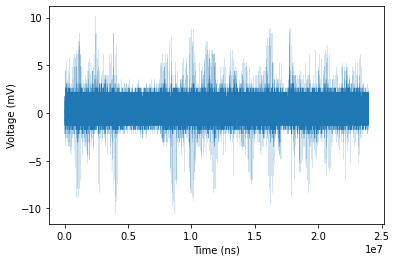

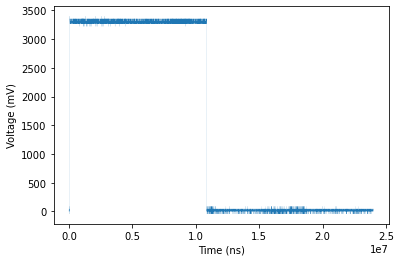

In [10]:
IS_SAVE = True
IS_DEBUG = True

if IS_SAVE:
    pt = b"\x00" * 16
    get_text = b"\x00" * 16
    trace_handler_chA.write_one_trace(text=pt+get_text, samples=np.asarray(bufferCompleteA, dtype=np.int16))
    trace_handler_chB.write_one_trace(text=pt+get_text, samples=np.asarray(bufferCompleteB, dtype=np.int16))


########################## debug lines
if IS_DEBUG:
    # print plain text
    # print(pt)
    # Creates the time data
    times = np.linspace(0, (totalSamples - 1) * actualSampleIntervalNs, totalSamples)

    # Converts ADC from channel A to mV
    adc2mVChAMax = adc2mV(bufferCompleteA, chARange, maxADC)
    adc2mVChBMax = adc2mV(bufferCompleteB, chBRange, maxADC)

    # Plots the data from channel A
    plt.figure()
    plt.plot(times, adc2mVChAMax[:], linewidth=0.1)
    plt.xlabel('Time (ns)')
    plt.ylabel('Voltage (mV)')
    plt.show()

    # Plots the data from channel B
    plt.figure()
    plt.plot(times, adc2mVChBMax[:], linewidth=0.1)
    plt.xlabel('Time (ns)')
    plt.ylabel('Voltage (mV)')
    plt.show()
    
    # plt.figure()
    # plt.plot(times, bufferBMax[:], linewidth=0.1)
    # plt.xlabel('Time (ns)')
    # plt.ylabel('ADC Buffer')
    # plt.show()

    # print(np.asarray(bufferAMax, dtype=np.int16))
    # print(np.asarray(bufferBMax, dtype=np.int16))

In [11]:
# # Step 5: Communication with the Target

# PORT = "/dev/ttyACM0"
# CMD_TINYAES_U = p8(0xA1) # uart tinyaes encryption
# CMD_COREMARK_U = p8(0xA2) # coremark
# CMD_ECDSA_U = p8(0xA3) # ecdsa
# PT_LEN = 0x10

# if "io" in globals():
#     io.close()

# io = serialtube(PORT, baudrate=115200)

# def reset_target():
#     cmd = 'nrfjprog --reset'
#     output_bytes = subprocess.check_output(cmd, shell=True)
#     print(output_bytes.decode('utf-8'))

# def send_line(bs: bytes):
#     # l = len(bs)
#     # io.send(p32(l))
#     io.sendline(bs.hex())

In [12]:
raise

RuntimeError: No active exception to reraise

In [ ]:
# Finally, Stop and Close the scope
status["stop"] = ps.ps3000aStop(chandle)
assert_pico_ok(status["stop"])

status["close"] = ps.ps3000aCloseUnit(chandle)
assert_pico_ok(status["close"])

# Displays the staus returns
print(status)

trace_handler_chB.close_write_fid()
trace_handler_chA.close_write_fid()

{'openunit': 0, 'setChA': 0, 'setChB': 0, 'maximumValue': 0, 'setDataBuffersA': 0, 'setDataBuffersB': 0, 'trigger': 0, 'runStreaming': 0, 'getStreamingLastestValues': 0, 'stop': 0, 'close': 0}


In [ ]:
raise

RuntimeError: No active exception to reraise

Mannul test

In [ ]:
import ctypes
import serial
from picosdk.ps3000a import ps3000a as ps
from picosdk.functions import mV2adc, adc2mV, assert_pico_ok
import numpy as np
import matplotlib.pyplot as plt
    
from pwn import *
from tqdm import tqdm
import random
import time

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from Trace_processor_pico3000a import TraceProcessor


TRACE_NUM = 1
PORT = "/dev/ttyACM0"
CMD_TINYAES_U = p8(0xA1) # uart tinyaes encryption
CMD_COREMARK_U = p8(0xA2)
CMD_ECDSA_U = p8(0xA3) # ecdsa
PT_LEN = 0x10
GET_PC_TRACE = False

if "io" in globals():
    io.close()

io = serialtube(PORT, baudrate=115200)

def reset_target():
    cmd = 'nrfjprog --reset'
    output_bytes = subprocess.check_output(cmd, shell=True)
    print(output_bytes.decode('utf-8'))

def send_line(bs: bytes):
    # l = len(bs)
    # io.send(p32(l))TRACE_NUM = 10
    io.sendline(bs.hex())

if GET_PC_TRACE:
    pass
else:
    reset_target()

io.recvuntil(b"READY\n")

# generate random plain text
random.seed(42)
pt = [bytes([random.randrange(0, 256) for _ in range(0, PT_LEN)]) for _ in range(TRACE_NUM)]

# collect the traces
while True:
# for i in tqdm(range(TRACE_NUM)):
    # send_line(CMD_TINYAES_U)
    # send_line(CMD_COREMARK_U)
    send_line(CMD_ECDSA_U)
    # send_line(pt[i])
    send_line(pt[0])
    data = io.recvuntil(b"DONE\n")
    # collect_one_trace()
    # print(i, data)
    print("YES!")
    sleep(1)

io.close()
print("All done.")

Applying system reset.
Run.



/tmp/ipykernel_444692/4283850263.py:40: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  io.sendline(bs.hex())


YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!


KeyboardInterrupt: 